In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

In [ ]:
drive.mount('/content/drive/')
path_project = "/content/drive/My Drive/malaria_segmentation" 
os.chdir(path_project)
print(os.getcwd())

Mounted at /content/drive/
/content/drive/My Drive/malaria_segmentation


# Redimencion de imagen y conversion RGB a escala de grises

In [ ]:
one_img = cv2.imread("Giemsa stained images/0.png")
print(one_img.shape)

(1030, 1382, 3)


In [ ]:
images = sorted(os.listdir(path_project + "/Giemsa stained images"))
groundtruths = sorted(os.listdir(path_project + "/Ground truth images"))

scale_percent = 70 # Porcentaje de la imagen original
resized_images = []
resized_groundtruths = []

for image in images:
    image_path = path_project + "/Giemsa stained images/" + image
    print(image_path)
    image = cv2.imread(image_path)
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_images.append(cv2.cvtColor(cv2.resize(image, dim, interpolation = cv2.INTER_AREA), cv2.COLOR_BGR2GRAY))

for groundtruth in groundtruths:
    groundtruth_path = path_project + "/Ground truth images/" + groundtruth
    print(groundtruth_path)
    groundtruth = cv2.imread(groundtruth_path)
    width = int(groundtruth.shape[1] * scale_percent / 100)
    height = int(groundtruth.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_groundtruths.append(cv2.cvtColor(cv2.resize(groundtruth, dim, interpolation = cv2.INTER_AREA), cv2.COLOR_BGR2GRAY))

new_images = np.asarray(resized_images)
new_groundtruth = np.asarray(resized_groundtruths)
print(new_images.shape)
print(new_groundtruth.shape)


/content/drive/My Drive/malaria_segmentation/Giemsa stained images/0.png
/content/drive/My Drive/malaria_segmentation/Giemsa stained images/1.png
/content/drive/My Drive/malaria_segmentation/Giemsa stained images/2.png
/content/drive/My Drive/malaria_segmentation/Giemsa stained images/3.png
/content/drive/My Drive/malaria_segmentation/Giemsa stained images/4.png
/content/drive/My Drive/malaria_segmentation/Giemsa stained images/5.png
/content/drive/My Drive/malaria_segmentation/Giemsa stained images/6.png
/content/drive/My Drive/malaria_segmentation/Giemsa stained images/7.png
/content/drive/My Drive/malaria_segmentation/Giemsa stained images/8.png
/content/drive/My Drive/malaria_segmentation/Giemsa stained images/9.png
/content/drive/My Drive/malaria_segmentation/Ground truth images/0.png
/content/drive/My Drive/malaria_segmentation/Ground truth images/1.png
/content/drive/My Drive/malaria_segmentation/Ground truth images/2.png
/content/drive/My Drive/malaria_segmentation/Ground truth

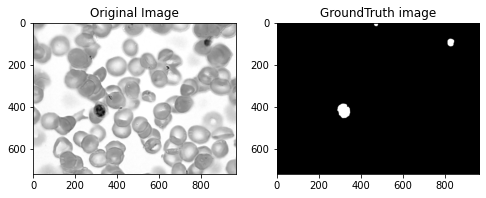

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,5), squeeze=False)

axs[0,0].set(title = 'Original Image')
axs[0,0].imshow(new_images[0], cmap = 'gray')
axs[0,1].set(title = 'GroundTruth image')
axs[0,1].imshow(new_groundtruth[0], cmap = 'gray')

plt.show()

# Implementando filtros - Extraccion de caracteristicas
### Gabor filters
$$g(x,y,\lambda,\theta,\psi,\sigma,\gamma) = exp\left(-\frac{x^2+\gamma^2y^2}{2\sigma^2}\right) exp\left(i\left(2\pi\frac{x}{\lambda}+\psi\right)\right) $$


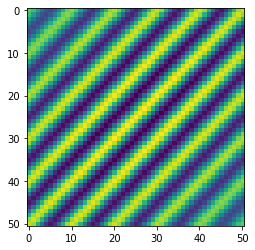

In [ ]:
ksize = 50
sigma = 30
theta = 1*np.pi/4
lamda = 1*np.pi/4
gamma = 0.5
phi = 0

kernel = cv2.getGaborKernel((ksize,ksize),sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)

plt.imshow(kernel)

In [ ]:
img = new_images[1]
img_reshape = img.reshape(-1) #flattening
print(img_reshape.shape)
df = pd.DataFrame()
df['original_pixels_image'] = img_reshape

(697207,)


In [ ]:
index = 1
kernels = []
for theta in range(2):
    theta = theta/np.pi*4
    for sigma in (1, 3):
        for lamda in np.arange(0,np.pi,np.pi/4):  
            for gamma in (0.05, 0.5):
              gabor_label = 'gabor_' + str(index)
              ksize=80
              kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
              kernels.append(kernel)
              f_img = cv2.filter2D(img_reshape, cv2.CV_8UC3, kernel)
              filtered_image = f_img.reshape(-1)
              df[gabor_label] = filtered_image 
              print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
              index = index + 1

gabor_1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
gabor_2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
gabor_3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
gabor_4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
gabor_5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
gabor_6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
gabor_7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
gabor_8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
gabor_9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
gabor_10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
gabor_11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
gabor_12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
gabor_13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
gabor_14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
gabor_15 : theta= 0.0 : sigm

In [ ]:
img_groundtruth = new_groundtruth[1]
img_groundtruth_1 = img_groundtruth.reshape(-1)
df['groundtruth'] = img_groundtruth_1

In [ ]:
df.head()

,original_pixels_image,gabor_1,gabor_2,gabor_3,gabor_4,gabor_5,gabor_6,gabor_7,gabor_8,gabor_9,...,gabor_24,gabor_25,gabor_26,gabor_27,gabor_28,gabor_29,gabor_30,gabor_31,gabor_32,groundtruth
0,177,0,0,255,255,255,156,255,63,0,...,75,0,0,0,0,0,0,0,0,0
1,170,0,0,255,255,255,155,255,63,0,...,62,0,0,0,0,0,0,0,0,0
2,163,0,0,255,255,255,153,255,62,0,...,55,0,0,3,0,0,0,0,0,0
3,159,0,0,255,255,255,151,255,61,0,...,55,0,0,1,0,0,0,0,0,0
4,157,0,0,255,255,255,149,255,60,0,...,54,0,0,0,0,0,0,1,0,0


# Definicion variables para modelos

In [ ]:
y = df['groundtruth'].values
x = df.drop(labels = ['groundtruth'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=30)

In [ ]:
ground_truth = np.reshape(y, img_groundtruth.shape)
accuracies = []

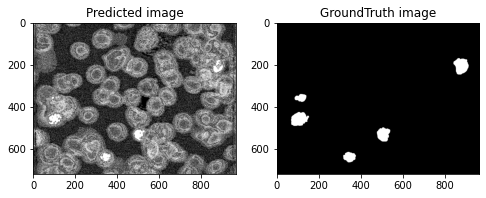

accuracy 0.317 


In [ ]:
#@title **Gaussian Naive Bayes**
est = GaussianNB()
est.fit(x_train,y_train)

y_prediction = est.predict(x_test)
accuracy = accuracy_score(y_prediction, y_test)

accuracies.append(accuracy)

prediction = est.predict(x)
predicted_mask_GNB = prediction.reshape(img.shape)

fig, axs = plt.subplots(1,2, figsize=(8,5), squeeze=False)
axs[0,0].set(title = 'Predicted image')
axs[0,0].imshow(predicted_mask_GNB, cmap = 'gray')
axs[0,1].set(title = 'GroundTruth image')
axs[0,1].imshow(ground_truth, cmap = 'gray')

plt.show()

print("accuracy %.3f " %(accuracy))

In [ ]:
#@title **Decision Tree Classifier** 
tree_depths = range(1, 10)
dict_accuracy = {}
for depth in tree_depths:
    est = DecisionTreeClassifier(max_depth=depth)
    est.fit(x_train,y_train)

    y_prediction = est.predict(x_test)
    accuracy = accuracy_score(y_prediction, y_test)
   
    dict_accuracy['max_depth_'+ str(depth)] = "%.3f "%accuracy
print(dict_accuracy)

{'max_depth_1': '0.993 ', 'max_depth_2': '0.993 ', 'max_depth_3': '0.994 ', 'max_depth_4': '0.994 ', 'max_depth_5': '0.994 ', 'max_depth_6': '0.994 ', 'max_depth_7': '0.994 ', 'max_depth_8': '0.994 ', 'max_depth_9': '0.994 '}


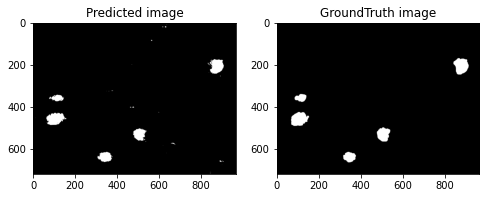

accuracy 0.994 
['gabor_6' 'gabor_19' 'gabor_21' 'original_pixels_image' 'gabor_8'
 'gabor_12' 'gabor_11' 'gabor_10' 'gabor_9' 'gabor_7' 'gabor_14' 'gabor_5'
 'gabor_4' 'gabor_3' 'gabor_2' 'gabor_1' 'gabor_13' 'gabor_32' 'gabor_15'
 'gabor_31' 'gabor_17' 'gabor_18' 'gabor_20' 'gabor_22' 'gabor_23'
 'gabor_24' 'gabor_25' 'gabor_26' 'gabor_27' 'gabor_28' 'gabor_29'
 'gabor_30' 'gabor_16']


In [ ]:
est = DecisionTreeClassifier(max_depth=3)
est.fit(x_train,y_train)
features = est.feature_importances_
bestfeat = np.argsort(features)[::-1]

y_prediction = est.predict(x_test)
accuracy = accuracy_score(y_prediction, y_test)

accuracies.append(accuracy)

prediction = est.predict(x)
predicted_mask_DTC = prediction.reshape(img.shape)

fig, axs = plt.subplots(1,2, figsize=(8,5), squeeze=False)

axs[0,0].set(title = 'Predicted image')
axs[0,0].imshow(predicted_mask_DTC, cmap = 'gray')
axs[0,1].set(title = 'GroundTruth image')
axs[0,1].imshow(ground_truth, cmap = 'gray')

plt.show()
print("accuracy %.3f " %(accuracy))
print(x_train.columns.values[bestfeat])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


Text(0, 0.5, 'Testing Accuracy')

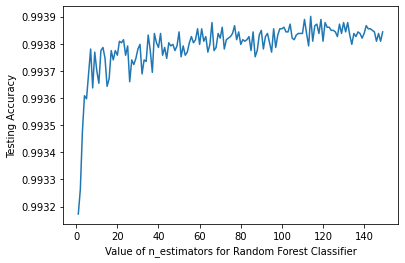

In [ ]:
#@title **Random Forest Classifier**
bestcols = []
for c in range(5):
  bestcols.append(bestfeat[c])

  x_train_best = x_train.iloc[:,bestcols]
  x_test_best = x_test.iloc[:,bestcols]

scores =[]

for i in range(1, 150):
    print(i)
    est = RandomForestClassifier(n_estimators=i)
    est.fit(x_train_best, y_train)
    y_pred = est.predict(x_test_best)
    scores.append(accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 150), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')


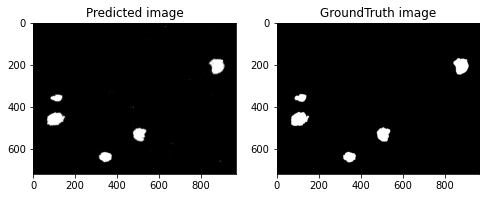

accuracy 0.994 


In [ ]:
est = RandomForestClassifier(n_estimators=115)
est.fit(x_train, y_train)
y_prediction = est.predict(x_test)


accuracy = accuracy_score(y_prediction, y_test)
accuracies.append(accuracy)

prediction = est.predict(x)
predicted_mask_RFC = prediction.reshape(img.shape)

fig, axs = plt.subplots(1,2, figsize=(8,5), squeeze=False)

axs[0,0].set(title = 'Predicted image')
axs[0,0].imshow(predicted_mask_RFC, cmap = 'gray')
axs[0,1].set(title = 'GroundTruth image')
axs[0,1].imshow(ground_truth, cmap = 'gray')

plt.show()
print("accuracy %.3f " %(accuracy))

In [ ]:
#@title **Support Vector Classifier**
est = LinearSVC(random_state=0, tol=1e-5,max_iter=500)
est.fit(x_train,y_train)

y_prediction = est.predict(x_test)
accuracy = accuracy_score(y_prediction, y_test)
accuracies.append(accuracy)


prediction = est.predict(x)
predicted_mask_SVC = prediction.reshape(img.shape)

fig, axs = plt.subplots(1,2, figsize=(8,5), squeeze=False)

axs[0,0].set(title = 'Predicted image')
axs[0,0].imshow(predicted_mask_SVC, cmap = 'gray')
axs[0,1].set(title = 'GroundTruth image')
axs[0,1].imshow(ground_truth, cmap = 'gray')

plt.show()
print("accuracy %.3f " %(accuracy))
